# Training Data

The training data is generated using real HSC images from the Ultra Deep (UD) field. The ground truth source detection masks are generated using the [scarlet](https://github.com/pmelchior/scarlet) deblender. HSC UD data can be accessed from https://hsc-release.mtk.nao.ac.jp/doc/index.php/tools-2/. We used the public DR2 UD stacks from: https://hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results. The HSC DR2 data is described in [Hiroaki et al. 2019](https://ui.adsabs.harvard.edu/abs/2019PASJ...71..114A/abstract).

In [1]:
# In case you need to point to pre-existing scarlet install
import sys
sys.path.insert(1, '/home/paleo2/.conda/envs/astro-det-scarlet2/lib/python3.7/site-packages/scarlet-1.0.1+gfde109a-py3.7-linux-ppc64le.egg/')

In [2]:
import sys, os
import numpy as np
import scarlet
import sep
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping
from astropy.nddata import Cutout2D

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt

# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')

In [3]:
# Print the versions to test the imports and so we know what works
print(scarlet.__version__)
print(np.__version__)
print(sep.__version__)

1.0.1+gfde109a
1.20.2
1.1.1


### Test Scarlet

First, let's test scarlet using one HSC UD image. The HSC image data is divided into "tracts" and "patches" on the sky. You can get the HSC image data given any ra, dec using the code below.

View HSC tract maps: https://hsc-release.mtk.nao.ac.jp/doc/index.php/data/

Tract, patch from coord: 9814 (6, 6)
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-G/9814/6,6/calexp-HSC-G-9814-6,6.fits".


/home/colinjb2/astrodet/astrodet/hsc.py:85: UserWarning: Overriding tract/patch info and looking for HSC file at requested coordinates.
  warnings.warn("Overriding tract/patch info and looking for HSC file at requested coordinates.")


Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-R/9814/6,6/calexp-HSC-R-9814-6,6.fits".
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/9814/6,6/calexp-HSC-I-9814-6,6.fits".


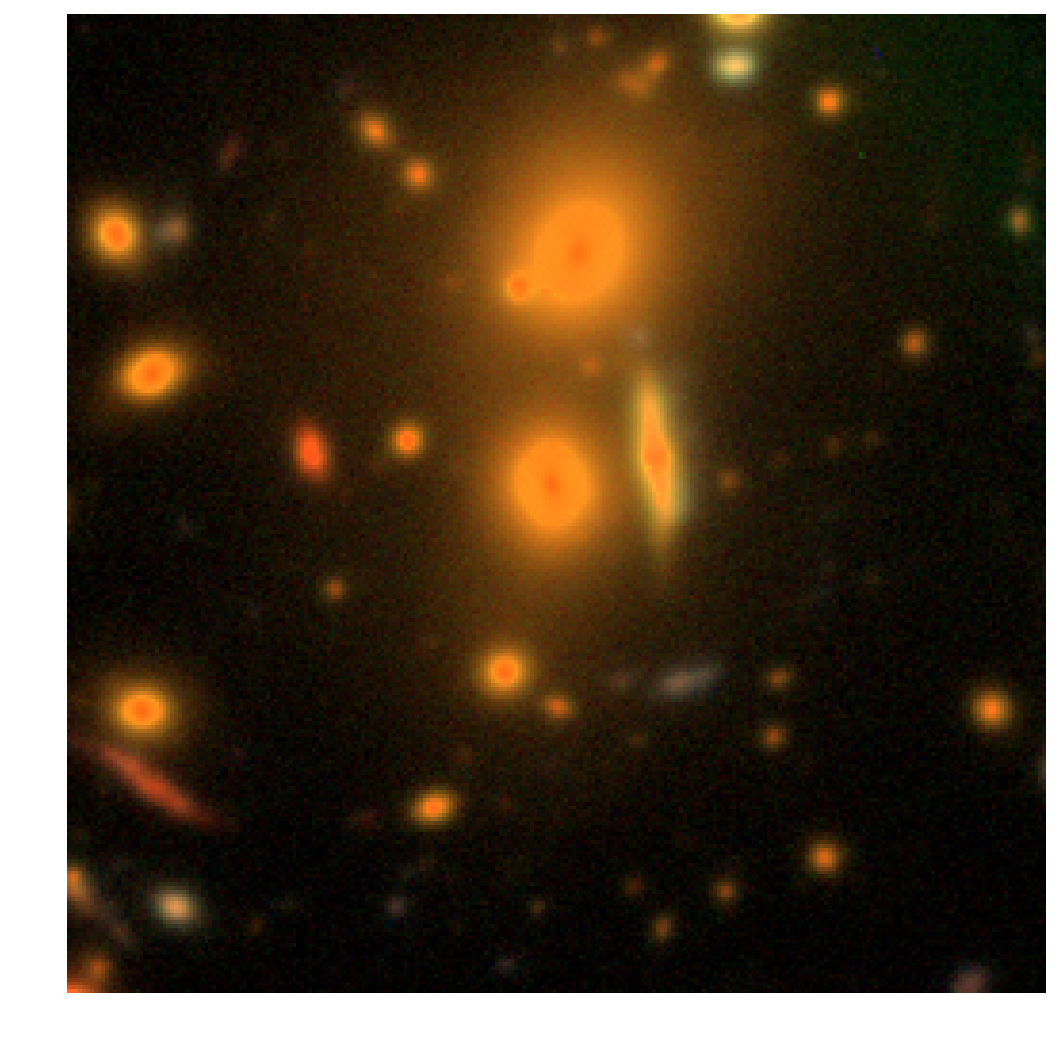

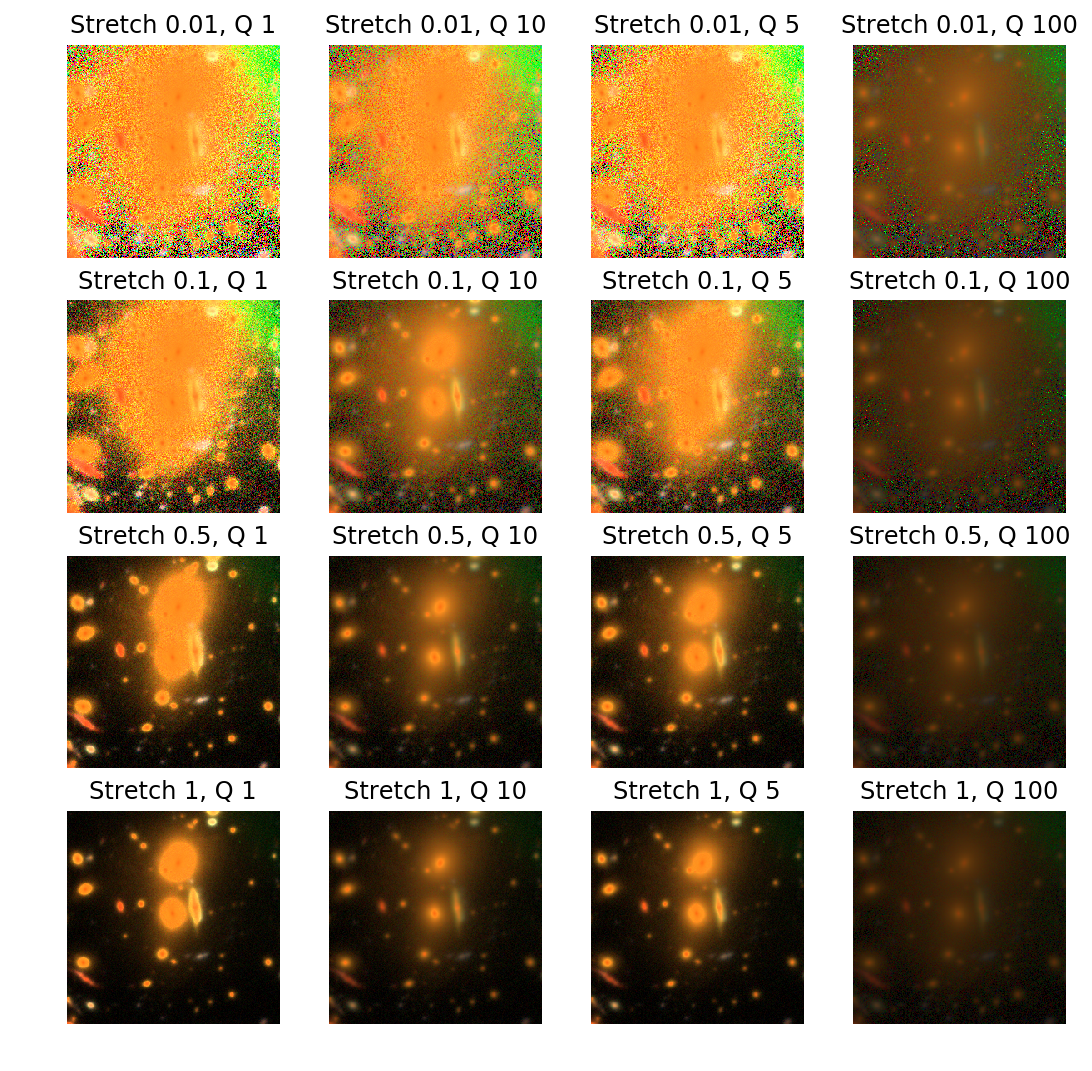

In [4]:
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord

from astrodet.hsc import get_tract_patch_from_coord, get_hsc_data
from astrodet.scarlet import plot_stretch_Q, run_scarlet, write_scarlet_results

filters = ['g', 'r', 'i']

# Input coordinate
c = SkyCoord(151.3816, 2.5854, unit='deg')

# Get the tract, patch
tract, patch = get_tract_patch_from_coord(c)
print('Tract, patch from coord:', tract, patch)

# Point to the HSC data directory
hsc_dirpath = '/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/'

# Get the HSC data from the file info
# If you want a cutout centered a coordinate, you can must pass the coord argument directly into get_hsc_data
# Otherwise, you can provide patch and tract and the cutout will be centered on the patch image center
cutout_size = [100,100]
datas = get_hsc_data(dirpath=hsc_dirpath, filters=filters, coord=c, cutout_size=cutout_size)

# Plot image data
fig, ax = plt.subplots(1, 1, figsize=(9,9))
norm = scarlet.display.AsinhMapping(minimum=0, stretch=1, Q=5)
img_rgb = scarlet.display.img_to_rgb(datas, norm=norm)
ax.imshow(img_rgb)
ax.axis('off')

# Find good stretch and Q
fig = plot_stretch_Q(datas);

# Run scarlet on image

sigma_obs: 2.0 pixels.
Source catalog found  49 objects
Initializing starlet sources to be fit.
Fitting Blend model.
Scarlet ran for 71 iterations to logL = -181570.47467045314


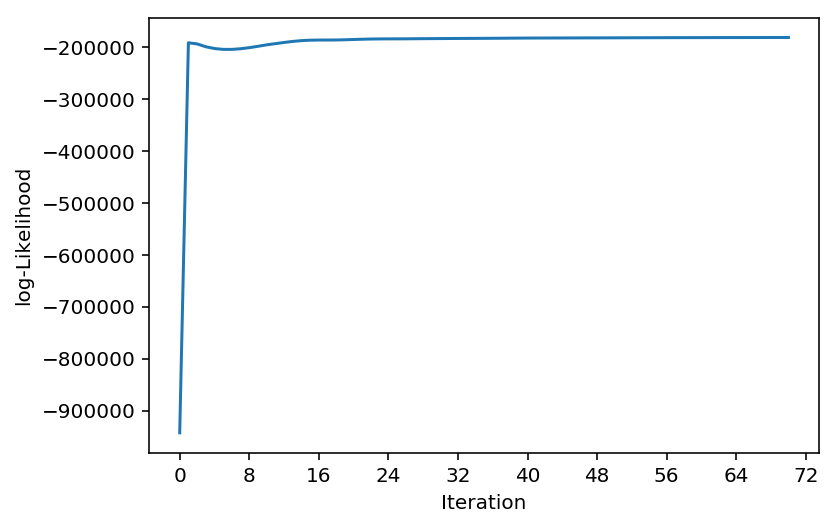

Computing residuals.
Re-fitting with Starlet models for poorly-fit sources.
Fitting Blend model.
Scarlet ran for 39 iterations to logL = -181391.36082036592


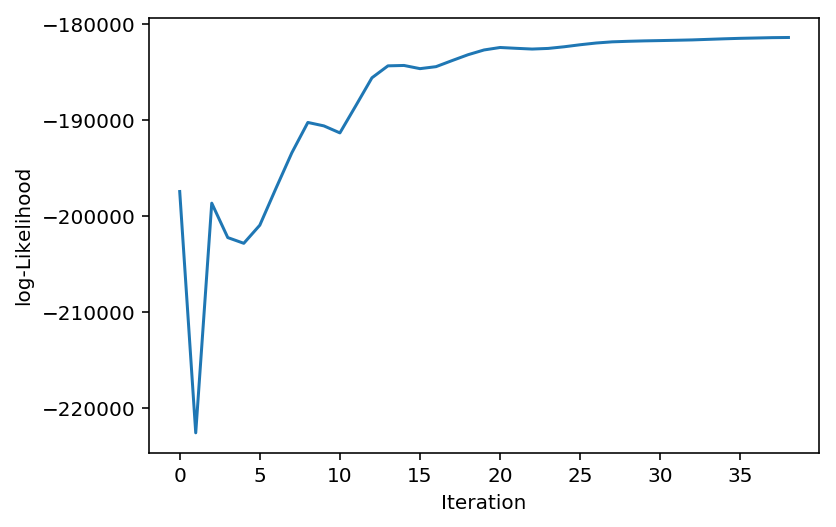

Extracting deblended catalog.


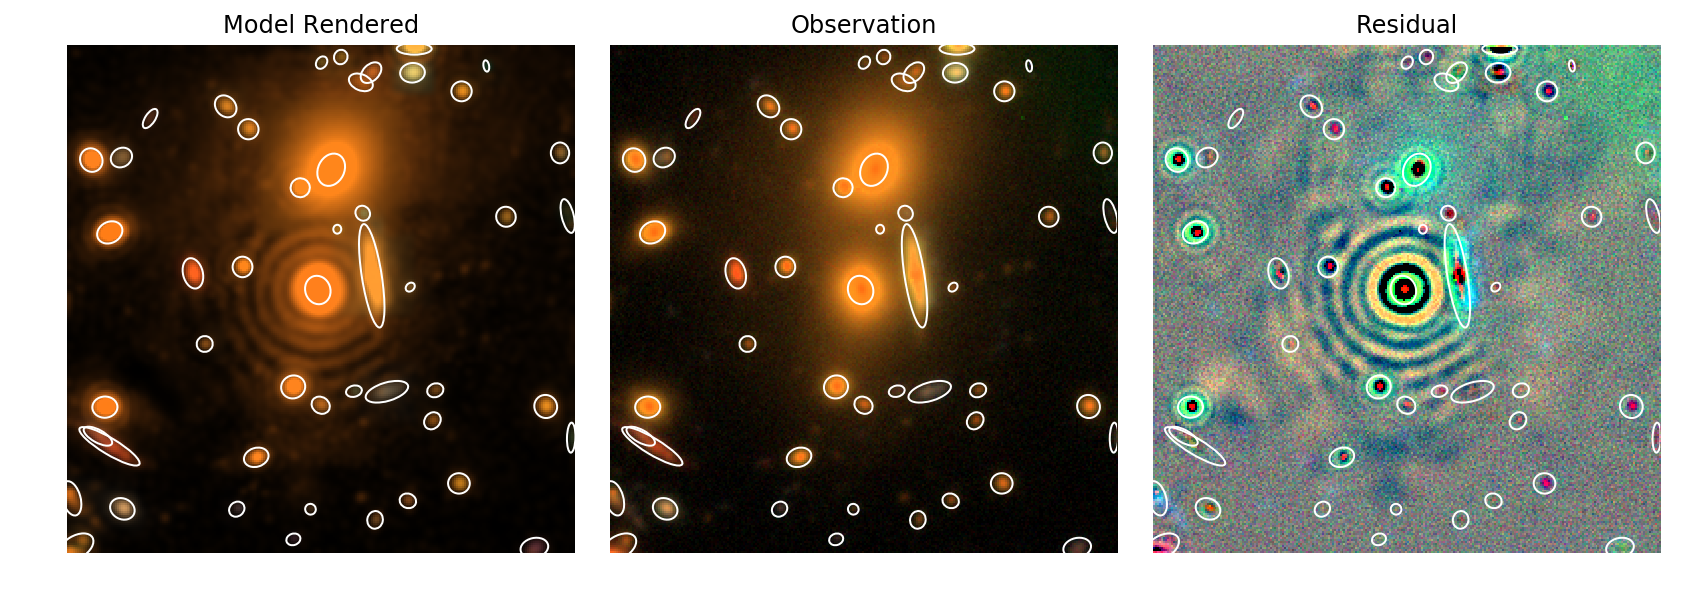

Writing scarlet results.


In [5]:
# HSC pixel scale in arcsec/pixel
ps = 0.17
# Approximate PSF size in UD field according to HSC DR2 paper is 0.8 arcsec
sigma_obs = gaussian_fwhm_to_sigma*0.8/ps
print(f'sigma_obs: {np.around(sigma_obs, 2)} pixels.')

# Run Scarlet
# START TIMING with plotting OFF
out = run_scarlet(datas, filters, sigma_model=1, sigma_obs=sigma_obs, plot_scene=True,
                  max_chi2=5000, morph_thresh=0.01, starlet_thresh=0.01, stretch=1, Q=5)
# END TIMING

# Unpack output
observation, starlet_sources, model_frame, catalog, catalog_deblended, segmentation_masks = out

print("Writing scarlet results.")

# Save Scarlet data to FITS file
filenames = write_scarlet_results(datas, observation, starlet_sources, model_frame, 
                                 catalog_deblended, segmentation_masks, dirpath='.', 
                                 filters=filters, tract=tract, patch=patch)

In [6]:
filepath = os.path.join('.', f'calexp-HSC-9814-6,6_scarlet_segmask.fits')
#filepath = os.path.join('.', f'calexp-HSC-G-9814-6,6_scarlet_img.fits')
#filepath = os.path.join('.', f'calexp-HSC-G-9814-6,6_scarlet_model.fits')


obs_hdul = fits.open(filepath)

In [7]:
obs_hdul[5].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                   32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   21                                                  
NAXIS2  =                   21                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
BBOX    = '113,12,21,21'                                                        
AREA    =                  441                                                  
ELL_PARM= '2.5254907608032227,2.0711026191711426,-0.4457484483718872'           
CAT_ID  =                    1                                                  

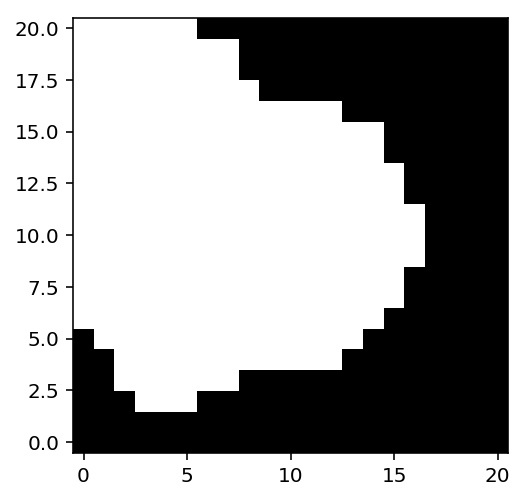

In [8]:
plt.imshow(obs_hdul[5].data)

In [ ]:
def generate_training_data(dirpath, filters=['g','r','i'], ratios=[1, 0.2, 0.2]):
    
    """
    Description.
    
    
    
    """
    
    import glob
    
    dirpath_write = os.path.join(dirpath, 'training_data')
    
    # HSC pixel scale in arcsec/pixel
    ps = 0.17
    # Approximate PSF size in UD field according to HSC DR2 paper is 0.8 arcsec
    sigma_obs = gaussian_fwhm_to_sigma*0.8/ps
        
    # Normalize ratios to sum to 1
    ratios = ratios / np.sum(ratios)
    
    # Get all HSC data
    files = []
    f = filters[0]
    f = f.upper()
    
    files = glob.glob(os.path.join(dirpath, f'HSC-{f}/**/**/calexp-HSC-{f}-*.fits.gz'), recursive=True)
    # Randomize file order
    np.random.shuffle(files)
            
    # Split dataset into training, validation, and test using ratios
    ln = len(files)
    i_train = int(np.floor(ln*ratios[0]))
    i_val = int(np.floor(ln*ratios[1]))
    i_test = int(np.floor(ln*ratios[1]))
    
    # Split using index
    files_val = files[:i_val]
    files_test = files[i_val:i_val + i_test]
    files_train = files[i_val + i_test:]
    
    # Run scarlet on training and test datasets
    for i, f in enumerate([files_train, files_test]):
        
        # Get tract, patch (use first band)
        for fi in f:
            
            # TODO: Do some multiprocessing

            s = fi.split(f'calexp-HSC-{f}-')[1].split('.fits.gz')[0]
            tract, patch = s.split('-')
            patch = tuple(map(int, patch.split(',')))
            
            # Run Scarlet
            out = run_scarlet(datas, filters, sigma_model=1, sigma_obs=sigma_obs, plot_scene=True,
                              max_chi2=5000, morph_thresh=0.01, starlet_thresh=0.01, stretch=1, Q=5)
            
            # Unpack output
            observation, starlet_sources, model_frame, catalog, catalog_deblended, segmentation_masks = out

            # Save Scarlet data to FITS file
            filenames = write_scarlet_results(datas, observation, starlet_sources, model_frame, 
                                             catalog_deblended, segmentation_masks, dirpath=dirpath_write, 
                                             filters=filters, tract=tract, patch=patch)
        
    return files_train, files_val, files_test

In [156]:
generate_training_data(hsc_dirpath)